In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04')
from KNMI_readers import read_knmi_uurgeg
from scipy.signal import welch

import puv 



In [2]:
def ossi_data_reader(datafolder):
    '''
    author: Paul van Wiechen

    Function to read all WLOG_XXX files in a certain subfolder.
    Make sure that only WLOG_XXX files are in this folder and no other files.
    Only WLOG_XXX files with minimally 2 rows are appended to the dataframe.
    A correct WLOG_XXX file should contain a first line with OSSI configuration, and a second line (third row) with starting time
    Timestep and sampling frequency are retrieved from the first row. Starting time from the next row
    Returns a dataframe with a time column and pressure column in dbars
    '''

    ossi = pd.DataFrame({
        't': [],
        'p': []})

    directory = str(datafolder)

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)

        # checking if it is a file
        if os.path.isfile(f):
            print('Currently concatenating file ' + f)
            ossi_raw = pd.read_csv(f, header=None, nrows=4, sep=',')
            if len(ossi_raw.index) > 2:
                t_0 = datetime(int(str(20) + ossi_raw[0][1][1:]), int(ossi_raw[1][1][1:]), int(ossi_raw[2][1][1:]),
                               int(ossi_raw[3][1][1:]), int(ossi_raw[4][1][1:]), int(ossi_raw[5][1][1:]))
                dt = 1 / float(ossi_raw[6][0][1:])
                ossi_tot = pd.read_csv(f, skiprows=3, usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], header=None,
                                       sep=',', skipinitialspace=True).to_numpy().flatten()
                ossi_temp = pd.DataFrame({
                    't': np.array([t_0 + timedelta(seconds=dt * i) for i in range(len(ossi_tot))]),
                    'p': ossi_tot})

                ossi_temp.dropna(inplace=True)
                ossi_temp['p'] = ossi_temp['p'] * 1e5  # Bar to Pa

                ossi = pd.concat([ossi, ossi_temp], ignore_index=True)

    ossi['p'] = pd.to_numeric(ossi['p'])
    ossi['t'] = pd.to_datetime(ossi['t'])

    return ossi.set_index('t')


In [3]:
experimentFolder = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04"    #Grand map
dfp = ossi_data_reader(os.path.join(experimentFolder,'OSSI_4_data'))                                                #specific map for data OSSI

instrument = 'OSSI_04'          # Specific name instrument
sf = 20                          # Hz, sampling frequency
xRD = 72478.479                   # location x-coord
yRD = 452138.636                   # location y-coord
serial_number = '18.09.00.08'    # unique serial number #not correct

rho = 1028      # Density of sea water
g = 9.81        # Gravitational force
zb = 0.687      # Height of sea bed    #23/12/2024
zi = 1.339      # Height of instrument

knmiFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\uurgeg_330_2021-2030.txt"

ds = dfp.to_xarray()
ds['p'] = ds.p.astype('int32')
ds.p.attrs = {'long_name': 'pressure', 'units': 'Pa'}

# add global attribute metadata
ds.attrs = {
    'Conventions': 'CF-1.6',
    'name': '{}'.format(instrument),
    'instrument': '{}'.format(instrument),
    'instrument type': 'OSSI',
    'instrument serial number': '{}'.format(serial_number),
    'epsg': 28992,
    'x': xRD,
    'y': yRD,
    'sf': 20,
    'time zone': 'UTC+2',
    'summary': 'Hybrid-dune experiment',
    'contact person': 'Ruben Rosman',
    'emailadres': 'r.g.c.rosman@student.tudelft.nl',
    'construction datetime': datetime.now().strftime("%d-%b-%Y (%H:%M:%S)"),
    'version': 'v1',
    'version comments': 'constructed with xarray'}

#if nothing else, at least specify lossless zlib compression
comp = dict(zlib=True, complevel=5)
ds.encoding = {var: comp for var in ds.data_vars}

# save to file
if not os.path.isdir(os.path.join(experimentFolder,'raw_netcdf')):
    os.mkdir(os.path.join(experimentFolder,'raw_netcdf'))
ncFilePath = os.path.join(experimentFolder, 'raw_netcdf', instrument + '.nc')
ds.to_netcdf(ncFilePath)


Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_data\WLOG_001.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_data\WLOG_002.CSV


C:\Users\ruro\AppData\Local\Temp\ipykernel_16748\1382462514.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ossi = pd.concat([ossi, ossi_temp], ignore_index=True)


Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_data\WLOG_003.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_data\WLOG_004.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_data\WLOG_005.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_data\WLOG_006.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_data\WLOG_007.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_data\WLOG_008.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\OSSI_4_dat

In [4]:
ds

<xarray.Dataset> Size: 236MB
Dimensions:  (t: 19661813)
Coordinates:
  * t        (t) datetime64[ns] 157MB 2024-12-16T08:01:00 ... 2024-12-27T17:1...
Data variables:
    p        (t) int32 79MB 6850 6850 6850 6850 6850 ... 8690 8690 8690 8690
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      OSSI_04
    instrument:                OSSI_04
    instrument type:           OSSI
    instrument serial number:  18.09.00.08
    epsg:                      28992
    ...                        ...
    summary:                   Hybrid-dune experiment
    contact person:            Ruben Rosman
    emailadres:                r.g.c.rosman@student.tudelft.nl
    construction datetime:     10-Feb-2025 (20:14:18)
    version:                   v1
    version comments:          constructed with xarray

In [5]:
dataFile = os.path.join(experimentFolder,'raw_netcdf', instrument +'.nc')
ds0 = xr.open_dataset(dataFile)
instr = ds0.instrument

# correct for the air pressure fluctuations and drift in the instrument
# first we load the data and add it to the dataset
dfp = read_knmi_uurgeg(knmiFile, 330)           # Adjust station number

dt = ((ds0.t[1] - ds0.t[0]) / np.timedelta64(1, 's')).values # target frequency

pAir = dfp['P'].to_xarray().sel(t=slice(ds0.t.min(), ds0.t.max())).resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds0['pAir'] = pAir.sel(t=slice(ds0.t.min(), ds0.t.max()))

pAir = dfp['P'].to_xarray().sel(t=slice(ds0.t.min(), ds0.t.max())).resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds0['pAir'] = pAir.sel(t=slice(ds0.t.min(), ds0.t.max()))

############
# we correct for drift in air pressure, nothing else
first_real_value = ds0['pAir'].dropna(dim='t', how='all').isel(t=0)
ds0['dpAir'] = ds0['pAir'] - first_real_value

# correct the pressure signal with dpAir and with drift in instrument pressure
ds0['pc'] = ds0['p'] -ds0['p'].min() - ds0['dpAir']
# ds0['pc'] = ds0['p'] -ds0['p'].min()
ds0['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure', 'comments': 'drift in air pressure is corrected'}

c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\KNMI_readers.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  t0 = pd.to_datetime(knmi.iloc[0]['YYYYMMDD'],format='%Y%m%d')+pd.Timedelta('{}H'.format(knmi.iloc[0]['HH']))
c:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\KNMI_readers.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t = pd.date_range(t0.to_datetime64(),periods=len(knmi),freq='1H')
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'S' is deprecated and will be 

In [7]:
# Specify your desired start timestamp
desired_start_time = pd.Timestamp("2024-09-26T00:00:00.00")

# Ensure both the desired start time and the time array are of type datetime64[ns]
desired_start_time = np.datetime64(desired_start_time)
time_array = ds0.t.values.astype("datetime64[ns]")  # Ensure time array is also datetime64[ns]

# Find the index corresponding to the closest time to the desired start time
start_index = np.searchsorted(time_array, desired_start_time)

# Ensure the index is valid and divisible by the burst length
dt = ds0.isel(t=1).t - ds0.isel(t=0).t  # Time step
sf = np.timedelta64(1, 's') / dt.values  # Sampling frequency

D_length = '1200S'

burstDuration = pd.Timedelta(D_length)  # Burst duration (1200 seconds = 20 minutes)
burstLength = int(burstDuration / dt)  # Number of samples per burst

# Adjust the starting index to align with the burst length
start_index = (start_index // burstLength) * burstLength

# Calculate the total number of samples and bursts
nSamples = len(ds0.pc.values)
nBursts = int(np.floor((nSamples - start_index) / burstLength))

# Subset the data starting from the adjusted index
pt = ds0.pc.values[start_index:start_index + nBursts * burstLength]
t = ds0.t.values[start_index::burstLength][:nBursts]  # Ensure time array is compatible

# Calculate the time vector for each burst
N = (time_array[:burstLength] - time_array[0]) / np.timedelta64(1, 's')

# Outputs
print(f"Start Index: {start_index}")
print(f"Number of Bursts: {nBursts}")
print(f"Sampling Frequency: {sf} Hz")
print(f"Time Vector (N): {N}")

# --------------------------------------------------------------------------
# cast into a 2D array
ds = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})
# copy all data over into this new structure
ds['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds['zi'] = zi
ds['zb'] = zb
ds['sf'] = sf

# remove all bursts where instrument fell dry
ds['p'] = ds.p.where(ds.p.std(dim='N') > 70)

# --------------------------------------------------------------------------
# pdb.set_trace()
ds['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
ds['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
ds['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}

ds.attrs = ds0.attrs
ds.attrs['summary'] = 'SEDMEX field campaign, pressure corrected for air pressure and cast in bursts of 10 minutes'
ds['name'] = instr
if not os.path.isdir(os.path.join(experimentFolder, 'QC')):
    os.mkdir(os.path.join(experimentFolder,'QC'))
ncFilePath = os.path.join(experimentFolder, 'QC', instr + '.nc')
ds.to_netcdf(ncFilePath)

Start Index: 0
Number of Bursts: 819
Sampling Frequency: 20.0 Hz
Time Vector (N): [0.00000e+00 5.00000e-02 1.00000e-01 ... 1.19985e+03 1.19990e+03
 1.19995e+03]


C:\Users\ruro\AppData\Local\Temp\ipykernel_16748\478218051.py:17: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  burstDuration = pd.Timedelta(D_length)  # Burst duration (1200 seconds = 20 minutes)


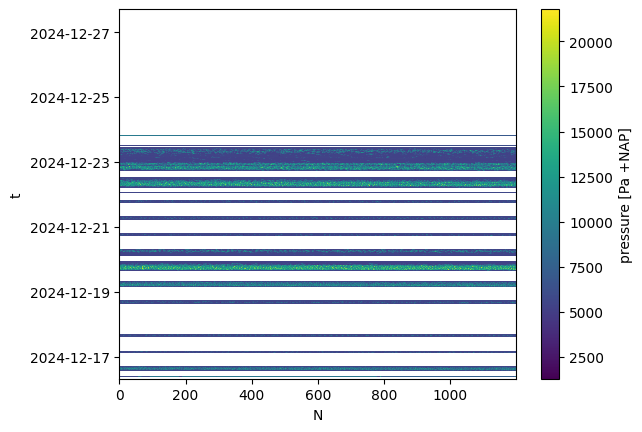

In [9]:
ds.p.plot();

In [10]:
# def find_burst_index_for_time(time_vector, burst_length, specific_time):
#     """
#     Find the burst index corresponding to a specific timestamp.

#     Parameters:
#         time_vector (numpy array): Array of timestamps for each burst.
#         burst_length (int): Number of samples per burst.
#         specific_time (str or pd.Timestamp): The specific time to search for.

#     Returns:
#         int: The burst index corresponding to the specific timestamp.
#     """
#     specific_time = np.datetime64(specific_time)  # Ensure the timestamp is datetime64
#     index = np.searchsorted(time_vector, specific_time)  # Find closest burst start
#     if index >= len(time_vector):
#         index = len(time_vector) - 1  # Handle case where timestamp is beyond the range
#     return index

# # Example usage of the function
# specific_time = pd.Timestamp("2024-12-22T17:00:00") 
# # specific_time = "2024-12-22T20:00:00"  # Replace with your desired time
# burst_index = find_burst_index_for_time(t, burstLength, specific_time)
# print(burst_index)

In [11]:
# %% input specification
# experimentFolder = r'c:\Users\marliesvanderl\phd\vakbegeleiding\CIE5318\2022\OSSI\data'
instrFile = os.path.join(experimentFolder,'QC', instrument +'.nc')
ncOutFile = os.path.join(experimentFolder,'tailored', instrument +'.nc')

# frequency resolution in fourier space
### delta_f = p_blocks/D_timeframe ###
sf = 20 
p_blocks = 20
D_length = 1200
fresolution = p_blocks / D_length
print(f'fresolution is: {fresolution}')
nperseg = D_length * sf / p_blocks - 0.5 #dim should be len(ds.f); whelch has (nperseg/2 +1)


# %% load the raw data from netcdf
ds0 = xr.open_dataset(instrFile)

#let's remove the bursts where there are only nans
ds0 = ds0.dropna(dim='t')

# make a new dataset that has an extra dimension to accomodate for the frequency axis
ds = xr.Dataset(data_vars={},
                coords={'t': ds0.t.values,
                        'N': ds0.N.values,
                        'f': np.arange(0, ds0.sf.values / 2, fresolution)})
ds['f'].attrs = {'units': 'Hz'}
ds.attrs = ds0.attrs

# put all variables in this new dataset
for key in ds0.data_vars:
    ds[key] = ds0[key]

# extract sampling frequency as explicit variable
sf = ds.f.values

# compute water depth
ds['h'] = (ds['p']/rho/g + ( ds['zi']-ds['zb'] )).mean(dim='N')
ds['h'].attrs = {'long_name': 'mean water level', 'units': 'm+NAP'}

fresolution is: 0.016666666666666666


In [12]:
# Several wave statistics computations, only based on pressure, for full bandpass

ufunc = lambda x, h: puv.attenuate_signal(
    'pressure', 
    ds.sf.values, x, h, 
    ds.zi.values,
    ds.zb.values,
    detrend=True)

fx, ds['zs'] = xr.apply_ufunc(ufunc, 
                              ds['p'], ds['h'],
                              input_core_dims=[['N'], []],
                              output_core_dims=[['f'], ['N']],
                              vectorize=True)
ds['zs'].attrs = {'units': 'm', 'long_name': 'surface elevation'}

# ds['zs'] = ds['zs'].where(ds['zs'] >= 0.0, drop=True)



ufunc = lambda p: welch(p, fs=ds.sf.values, nperseg=nperseg, detrend='constant', window='hann')

ds['frequencies'], ds['psd'] = xr.apply_ufunc(ufunc,
                                                ds['zs'],
                                                input_core_dims=[['N']],
                                                output_core_dims=[['f'], ['f']],
                                                vectorize=True)

ufunc = lambda psd: puv.compute_wave_params(ds.f.values, psd, fmin=0.5 , fmax=5)

ds['Hm0'], ds['Tp'], ds['Tm01'], ds['Tm02'], ds['Tmm10'], ds['Tps'] = xr.apply_ufunc(ufunc,
                                                                          ds['psd'],
                                                                          input_core_dims=[['f']],
                                                                          output_core_dims=[[], [], [], [], [], []],
                                                                          vectorize=True)



c:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\puv.py:351: RuntimeWarning: overflow encountered in cosh
  Sw = np.cosh(k*h)/np.cosh(k*elev)
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[index] = result


In [13]:
## low frequencies: IG waves ##
## now first filter bandpass, then compute wave_params

ufunc = lambda x: puv.band_pass_filter2(ds.sf.values, x, fmin=0.004, fmax=0.05)

ds['p_low'] = xr.apply_ufunc(ufunc, 
                          ds['p'],
                          input_core_dims=[['N']],
                          output_core_dims=[['N']],
                          vectorize=True)

ufunc = lambda x, h: puv.attenuate_signal(
    'pressure', 
    ds.sf.values, x, h, 
    ds.zi.values,
    ds.zb.values,
    detrend=True)

fx, ds['zs_low'] = xr.apply_ufunc(ufunc, 
                              ds['p_low'], ds['h'],
                              input_core_dims=[['N'], []],
                              output_core_dims=[['f'], ['N']],
                              vectorize=True)
ds['zs_low'].attrs = {'units': 'm', 'long_name': 'surface elevation low freq.'}
# ds['zs_low'] = ds['zs_low'].where(ds['zs_low'] >= 0.0, drop=True)

ufunc = lambda p: welch(p, fs=ds.sf.values, nperseg=nperseg, detrend='constant', window='hann')

ds['frequencies_low'], ds['psd_low'] = xr.apply_ufunc(ufunc,
                                                ds['zs_low'],
                                                input_core_dims=[['N']],
                                                output_core_dims=[['f'], ['f']],
                                                vectorize=True)

ufunc = lambda psd: puv.compute_wave_params(ds.f.values, psd, fmin=0.5 , fmax=5)

ds['Hm0_low'], ds['Tp_low'], ds['Tm01_low'], ds['Tm02_low'], ds['Tmm10_low'], ds['Tps_low'] = xr.apply_ufunc(ufunc,
                                                                          ds['psd_low'],
                                                                          input_core_dims=[['f']],
                                                                          output_core_dims=[[], [], [], [], [], []],
                                                                          vectorize=True)




In [14]:
## High frequencies: wind-waves ##
## now first filter bandpass, then compute wave_params

ufunc = lambda x: puv.band_pass_filter2(ds.sf.values, x, fmin=0.05, fmax=5)

ds['p_high'] = xr.apply_ufunc(ufunc, 
                          ds['p'],
                          input_core_dims=[['N']],
                          output_core_dims=[['N']],
                          vectorize=True)

ufunc = lambda x, h: puv.attenuate_signal(
    'pressure', 
    ds.sf.values, x, h, 
    ds.zi.values,
    ds.zb.values,
    detrend=True)

t, ds['zs_high'] = xr.apply_ufunc(ufunc, 
                              ds['p_high'], ds['h'],
                              input_core_dims=[['N'], []],
                              output_core_dims=[['f'], ['N']],
                              vectorize=True)
ds['zs_high'].attrs = {'units': 'm', 'long_name': 'surface elevation high freq.'}

# ds['zs_high'] = ds['zs_high'].where(ds['zs_high'] >= 0.0, drop=True)

ufunc = lambda p: welch(p, fs=ds.sf.values, nperseg=nperseg, detrend='constant', window='hann')

ds['frequencies_high'], ds['psd_high'] = xr.apply_ufunc(ufunc,
                                                ds['zs_high'],
                                                input_core_dims=[['N']],
                                                output_core_dims=[['f'], ['f']],
                                                vectorize=True)

ufunc = lambda psd: puv.compute_wave_params(ds.f.values, psd, fmin=0.5 , fmax=5)

ds['Hm0_high'], ds['Tp_high'], ds['Tm01_high'], ds['Tm02_high'], ds['Tmm10_high'], ds['Tps_high'] = xr.apply_ufunc(ufunc,
                                                                          ds['psd_high'],
                                                                          input_core_dims=[['f']],
                                                                          output_core_dims=[[], [], [], [], [], []],
                                                                          vectorize=True)


In [15]:
## skewness of waves ##
ufunc = lambda p: puv.compute_SkAs(sf,p,fpfac =None, fbounds = None)

ds['Sk'], ds['As'], ds['sig'] =  xr.apply_ufunc(ufunc,
                                                ds['p'], 
                                                input_core_dims=[['N']],
                                                output_core_dims=[[], [], []],
                                                vectorize=True)


In [16]:
# %% write to file
# we strip all information on burst scale from the dataset to reduce size (and this info is already present in the raw_netcdf version of the data)
dsTailored = ds.drop_dims('N')
if not os.path.isdir(os.path.join(experimentFolder,'tailored')):
    os.mkdir(os.path.join(experimentFolder,'tailored'))
ncFilePath = os.path.join(experimentFolder, 'tailored', ds0.instrument + '.nc')
dsTailored.to_netcdf(ncFilePath)

In [18]:
import matplotlib.pyplot as plt


# Create a continuous time array
t_continuous = np.array([t + np.timedelta64(int(n), 's') for t in ds.t.values for n in ds.N.values])

# Flatten the burst structure for plotting
zs_flat = ds.zs.values.flatten()
zs_low_flat = ds.zs_low.values.flatten()
zs_high_flat = ds.zs_high.values.flatten()



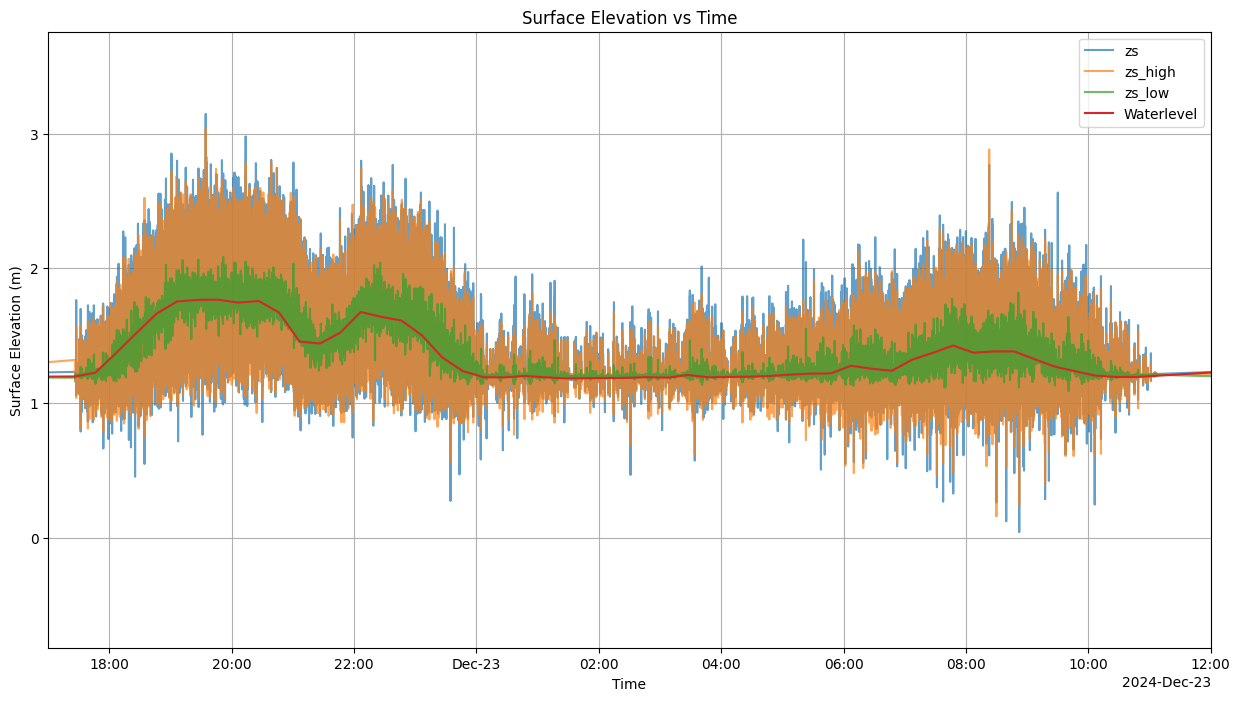

In [19]:
# Plotting
plt.figure(figsize=(15, 8))

plt.plot(t_continuous, zs_flat, label='zs', alpha=0.7)
plt.plot(t_continuous, zs_high_flat, label='zs_high', alpha=0.7)
plt.plot(t_continuous, zs_low_flat, label='zs_low', alpha=0.7)

ds.h.plot(label='Waterlevel')

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-22T17:00:00")
end_time = pd.Timestamp("2024-12-23T12:00:00")
plt.xlim(start_time, end_time)

plt.xlabel('Time')
plt.ylabel('Surface Elevation (m)')
plt.title('Surface Elevation vs Time')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
print(ds.zs.mean())
print(ds.h.mean())
print(zi-zb)
print(ds.zs.mean()-ds.h.mean())

<xarray.DataArray 'zs' ()> Size: 8B
array(1.39955011)
<xarray.DataArray 'h' ()> Size: 8B
array(1.37918882)
0.6519999999999999
<xarray.DataArray ()> Size: 8B
array(0.02036129)


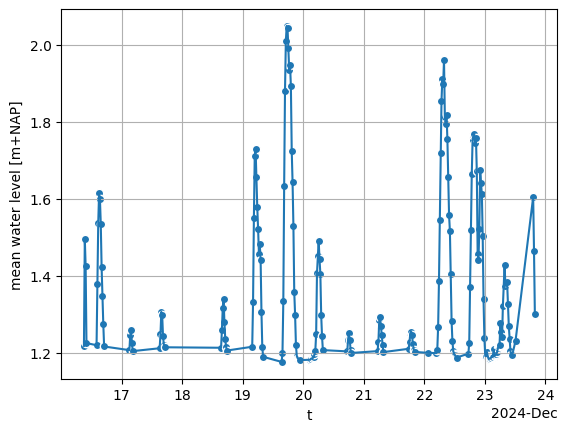

In [21]:
ds.h.plot()
ds.h.plot.scatter(x='t', y='h')
plt.grid()

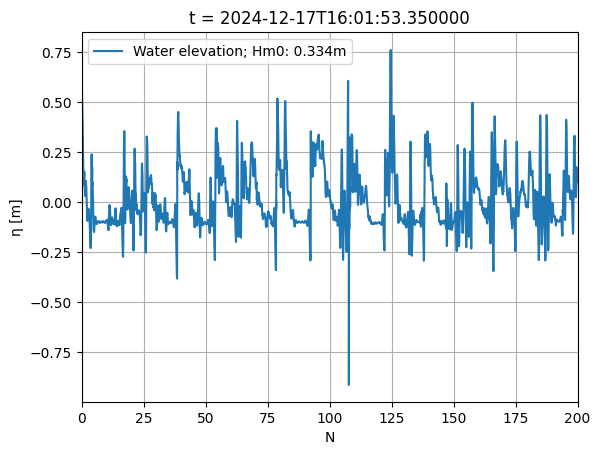

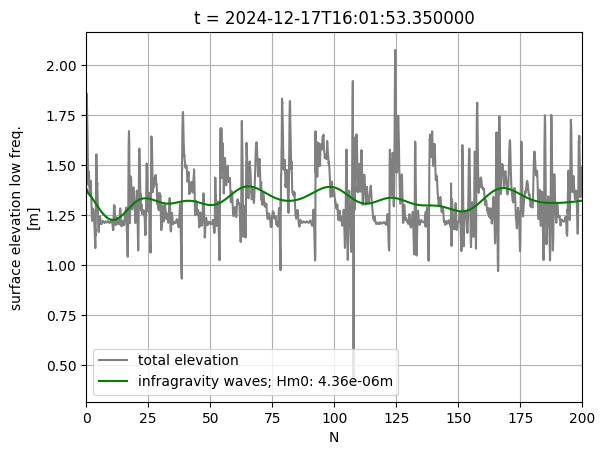

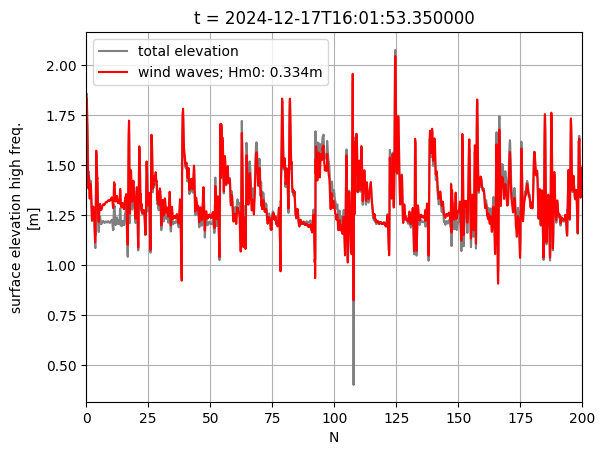

In [22]:
t = 22
end =200

plt.figure()
(ds.zs.isel(t=t)-ds.zs.isel(t=t).mean()).plot(label = f'Water elevation; Hm0: {ds.Hm0.isel(t=t).values:.3g}m')
plt.grid()
plt.xlim(0,end)
plt.ylabel(f'\u03B7 [m]')
plt.legend()

plt.figure()
ds.zs.isel(t=t).plot(color='grey', label= 'total elevation')
ds.zs_low.isel(t=t).plot(color='green', label = f'infragravity waves; Hm0: {ds.Hm0_low.isel(t=t).values:.3g}m')
plt.grid()
plt.xlim(0,end)
plt.legend()

plt.figure()
ds.zs.isel(t=t).plot(color='grey', label= 'total elevation')
ds.zs_high.isel(t=t).plot(color='red', label = f'wind waves; Hm0: {ds.Hm0_high.isel(t=t).values:.3g}m')

plt.grid()
plt.xlim(0,end)
plt.legend();

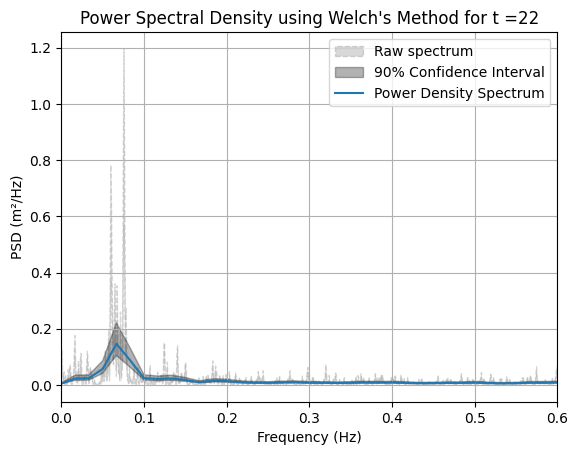

In [23]:
from scipy.stats import chi2
t=22
freq = ds.frequencies.isel(t=t)
psd = ds.psd.isel(t=t)


# Calculate confidence intervals
nBlocks = len(ds.zs.isel(t=t)) // nperseg  # Estimate the number of blocks used by Welch's method
edf = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
alpha = 0.1                  # 90% confidence level

confLow = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit

# Confidence interval bounds for PSD
psd_lower = psd * confLow
psd_upper = psd * confUpper



### background plot 
freq_bg, psd_bg = welch(ds.zs.isel(t=t).values, fs=20, nperseg=24000, detrend='constant', window='hann')
nBlocks_bg = len(ds.zs.isel(t=t).values) // 24000  # Estimate the number of blocks used by Welch's method
edf_bg = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
confLow_bg = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper_bg = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit
psd_lower_bg = psd_bg * confLow_bg
psd_upper_bg = psd_bg * confUpper_bg
# plt.plot(freq_bg, psd_upper_bg, color='gray', linestyle= '--')
plt.fill_between(freq_bg, psd_lower_bg, psd_upper_bg, color='gray', alpha=0.3, label='Raw spectrum', linestyle='--')

### plotting
plt.fill_between(freq, psd_lower, psd_upper, color='black', alpha=0.3, label='90% Confidence Interval')
plt.semilogy(freq, psd, label='Power Density Spectrum')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.title(f'Power Spectral Density using Welch\'s Method for t ={t}')
plt.grid()
plt.yscale('linear')
# plt.xscale('log')
plt.xscale('linear')
plt.xlim(0,0.6)
plt.legend()
plt.show()